In [5]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import random
from torchsummary import summary
from sklearn.model_selection import train_test_split
import shutil

'''Load data'''
temp_Qd = np.load('Data_processed/Qd_100.npy',allow_pickle=True).item()
temp_life = np.load('Data_processed/cycle_life.npy',allow_pickle=True).item()
all_capacity = np.load('Data_processed/all_capacity.npy',allow_pickle=True).item()
temp_Qd_all = []
temp_life_all = []
all_capacity_all = []

for key in temp_Qd.keys():
    temp_life_all.append(temp_life[key])
    all_capacity_all.append(all_capacity[key])
    temp_Qd_list = []
    for item in temp_Qd[key]:
        temp_Qd_list.append(item)
    temp_Qd_arr = np.asarray(temp_Qd_list)
    temp_Qd_all.append(temp_Qd_arr)
all_Qd_arr = np.asarray(temp_Qd_all)
cycle_life_arr = np.asarray(temp_life_all)    


'''Divide the dataset as the original paper stated'''
test_ind = np.hstack((np.arange(0,(41+43),2),83))
train_ind = np.arange(1,(41+43-1),2)
secondary_test_ind = np.arange(124-40,124)

all_keys = list(temp_Qd.keys())
train_keys = [all_keys[inx] for inx in train_ind]
test_keys = [all_keys[inx] for inx in test_ind]
secondary_test_keys = [all_keys[inx] for inx in secondary_test_ind]

cycle_life_arr=np.asarray(cycle_life_arr).reshape(-1,1)
max_label=np.max(cycle_life_arr)
cycle_life_arr=cycle_life_arr/max_label


train_Qds = np.asarray(all_Qd_arr)[train_ind]
train_cycle_lifes = np.asarray(cycle_life_arr)[train_ind]

test_Qd_a = np.asarray(all_Qd_arr)[test_ind]
test_cycle_life_a = np.asarray(cycle_life_arr)[test_ind]

test_Qd_b = np.asarray(all_Qd_arr)[secondary_test_ind]
test_cycle_life_b = np.asarray(cycle_life_arr)[secondary_test_ind]

train_Qd, _, train_cycle_life, _ = train_test_split(train_Qds, train_cycle_lifes, test_size=0.36, random_state=3)

'''Define the CNN model''' 
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.layer1=torch.nn.Sequential(
                        torch.nn.Conv2d(1, 8, kernel_size=(50,50), stride=(5,40)),
                        torch.nn.BatchNorm2d(8),
                        torch.nn.LeakyReLU(inplace=True),
                        torch.nn.MaxPool2d(kernel_size=2, stride=1))

        self.layer2=torch.nn.Sequential(
                        torch.nn.Conv2d(8, 16, kernel_size=(2,3), stride=1),
                        torch.nn.BatchNorm2d(16),
                        torch.nn.LeakyReLU(inplace=True))
        
        self.layer3=torch.nn.Sequential(
                        torch.nn.Conv2d(16, 32, kernel_size=(2,3), stride=1),
                        torch.nn.BatchNorm2d(32),
                        torch.nn.LeakyReLU(inplace=True))
        
        self.layer4=torch.nn.Sequential(
                        torch.nn.Conv2d(32, 64, kernel_size=(2,2), stride=1),
                        torch.nn.BatchNorm2d(64),
                        torch.nn.LeakyReLU(inplace=True))
        
        self.layer5=torch.nn.Sequential(
                        torch.nn.Conv2d(64, 64, kernel_size=(1,2), stride=1),
                        torch.nn.BatchNorm2d(64),
                        torch.nn.LeakyReLU(inplace=True))   
        self.drop_layer1 = torch.nn.Dropout(p=0.2)
        self.drop_layer3 = torch.nn.Dropout(p=0.4)
        self.drop_layer4 = torch.nn.Dropout(p=0.4)
        self.drop_layer5 = torch.nn.Dropout(p=0.2)
        self.drop_layer6 = torch.nn.Dropout(p=0.2)
        self.drop_layer7 = torch.nn.Dropout(p=0.4)
        
        self.fc1 = torch.nn.Linear(4864,100)
        self.fc2 = torch.nn.Linear(100,1)       
    
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)     
        x = self.layer3(x)                   
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.drop_layer6(x)                     
        x = torch.sigmoid(self.fc2(x))        
        return x



Net(
  (layer1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(50, 50), stride=(5, 40))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(2, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
  )
  (layer3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(2, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
  )
  (layer4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01, inplace=Tr

C:\Users\Fisher Man\AppData\Local\Temp\ipykernel_31812\230823248.py:74: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  a = model.load_state_dict(torch.load('Best_target_model

mpe_train: 0.06297971
mpe_val: 0.06487053
mpe_a: 0.10443372808825281
mpe_b: 0.11632744127639423
rmse_train: 53.33674
rmse_val: 55.007095
rmse_a: 87.58928998987395
rmse_b: 158.19394741898313


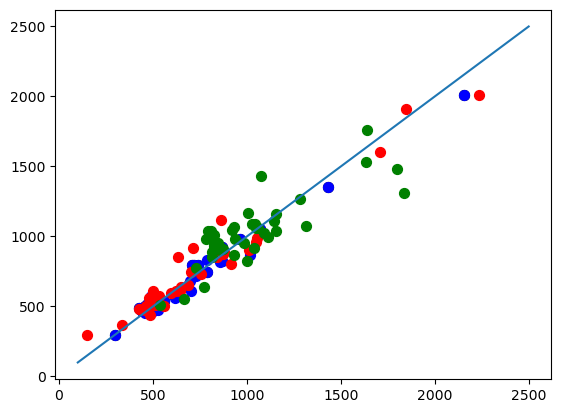

In [6]:

'''Data loader for Pytorch'''
input_train = torch.FloatTensor(train_Qd)
input_train = torch.unsqueeze(input_train, 1)
train_labels = torch.FloatTensor(train_cycle_life)

input_val = torch.FloatTensor(train_Qds)
input_val = torch.unsqueeze(input_val, 1)
val_labels = torch.FloatTensor(train_cycle_lifes)

input_test_a = torch.FloatTensor(test_Qd_a)
input_test_a = torch.unsqueeze(input_test_a, 1)
test_labels_a = torch.FloatTensor(test_cycle_life_a)

input_test_b = torch.FloatTensor(test_Qd_b)
input_test_b = torch.unsqueeze(input_test_b, 1)
test_labels_b = torch.FloatTensor(test_cycle_life_b)



seed = 17
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
np.random.seed(seed)  # Numpy module.
random.seed(seed)  # Python random module.
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
torch.manual_seed(seed)    # reproducible    


net = Net()     # define the network
print(net)      # net architecture
summary(net,(1,100,1000))

optimizer = torch.optim.Adam(net.parameters(), lr=0.00001)
loss_func = torch.nn.MSELoss() 

val_losses=[]

for t in range(1000):
    net.train()
    train_prediction = net(input_train)
    train_loss = loss_func(train_prediction, train_labels)
   
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

    '''save all the model in each epoch'''    
    torch.save({
        'epoch': t,
        'model_state_dict': net.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()}, 'Target_model/net_parameters'+str(t)+'.pkl')
        
    net.eval()
    with torch.no_grad():
        val_prediction = net(input_val)
        val_loss = loss_func(val_prediction, val_labels)
    print ('Step = %d' % t, 'train_loss:',train_loss.data.numpy(),'val_loss:',val_loss.data.numpy())
    val_losses.append(val_loss)
    
   
'''find the best model'''
best_index=val_losses.index(np.min(val_losses))
print(best_index)

'''copy the best model from model file to the model_test file'''
if 1:
    shutil.copyfile('Target_model/net_parameters'+str(best_index)+'.pkl', 'Best_target_model/net_parameters.pkl')

'''Reload the best model''' 
model = Net()
a = model.load_state_dict(torch.load('Best_target_model/net_parameters.pkl')['model_state_dict'])
optimizer.load_state_dict(torch.load('Best_target_model/net_parameters.pkl')['optimizer_state_dict'])


'''Prediction using the best model'''
predict_labels_a=[]
predict_labels_b=[]
predict_labels_train=[]
predict_labels_val = []
model.eval()
with torch.no_grad():
    predict_labels_a.append(model(input_test_a).data.numpy())
    predict_labels_b.append(model(input_test_b).data.numpy())
    
    predict_labels_train.append(model(input_train).data.numpy())   
    predict_labels_val.append(model(input_val).data.numpy())      


actual_label_arr_train=np.round(np.asarray(train_labels*max_label).reshape(-1,1))  
predict_label_arr_train=np.round(np.asarray(predict_labels_train).reshape(-1,1)*max_label)


actual_label_arr_val=np.round(np.asarray(val_labels*max_label).reshape(-1,1))   
predict_label_arr_val=np.round(np.asarray(predict_labels_val).reshape(-1,1)*max_label)


actual_label_arr_a=np.round(np.asarray(test_cycle_life_a*max_label).reshape(-1,1))   
predict_label_arr_a=np.round(np.asarray(predict_labels_a).reshape(-1,1)*max_label)


actual_label_arr_b=np.round(np.asarray(test_cycle_life_b * max_label).reshape(-1,1))   
predict_label_arr_b=np.round(np.asarray(predict_labels_b).reshape(-1,1)*max_label)


'''Plot the predicted cycle lives'''
plt.scatter(actual_label_arr_train, predict_label_arr_train,s=50,c='k')
plt.scatter(actual_label_arr_val, predict_label_arr_val,s=50,c='b')
plt.scatter(actual_label_arr_a, predict_label_arr_a,s=50,c='r')
plt.scatter(actual_label_arr_b, predict_label_arr_b,s=50,c='g')
plt.plot([100,2500],[100,2500])


'''Evaluation metrics'''
mpe_a=np.mean(np.abs(predict_label_arr_a-actual_label_arr_a)/actual_label_arr_a)
mpe_b=np.mean(np.abs(predict_label_arr_b-actual_label_arr_b)/actual_label_arr_b)
mpe_train = np.mean(np.abs(predict_label_arr_train-actual_label_arr_train)/actual_label_arr_train)
mpe_val = np.mean(np.abs(predict_label_arr_val-actual_label_arr_val)/actual_label_arr_val)


rmse_a=np.sqrt(np.mean((predict_label_arr_a-actual_label_arr_a)**2))
rmse_b=np.sqrt(np.mean((predict_label_arr_b-actual_label_arr_b)**2))
rmse_train=np.sqrt(np.mean((predict_label_arr_train-actual_label_arr_train)**2))
rmse_val=np.sqrt(np.mean((predict_label_arr_val-actual_label_arr_val)**2))


print ('mpe_train:',mpe_train)
print ('mpe_val:',mpe_val)
print ('mpe_a:',mpe_a)
print ('mpe_b:',mpe_b)

print ('rmse_train:', rmse_train)
print ('rmse_val:', rmse_val)
print ('rmse_a:', rmse_a)
print ('rmse_b:', rmse_b)